In [ ]:
임베딩 알고리즘 변경
분류 알고리즘 변경 

In [1]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5435437857735736915
 xla_global_id: -1]

In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [7]:
import re 

def clean_text(texts): 
  corpus = [] 
  for i in range(0, len(texts)): 

    review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>]', '',texts[i]) #@%*=()/+ 와 같은 문장부호 제거
    review = re.sub(r'\d+','', review)#숫자 제거
    review = review.lower() #소문자 변환
    review = re.sub(r'\s+', ' ', review) #extra space 제거
    review = re.sub(r'<[^>]+>','',review) #Html tags 제거
    review = re.sub(r'\s+', ' ', review) #spaces 제거
    review = re.sub(r"^\s+", '', review) #space from start 제거
    review = re.sub(r'\s+$', '', review) #space from the end 제거
    review = re.sub(r'_', ' ', review) #space from the end 제거
    corpus.append(review) 
  
  return corpus

In [8]:
temp = clean_text(train['text']) #메소드 적용
train['text'] = temp
train.head()

,text,target
0,they were and even if washington might conside...,10
1,we run spacenews views on our stareach bbs a l...,14
2,not to worry the masons have been demonized an...,19
3,only brendan mckay or maybe arf would come to ...,17
4,help i am running some sample problems from or...,5


In [9]:
temp = clean_text(test['text']) #메소드 적용
test['text'] = temp
test.head()

,text
0,the vlide adapter can be much faster then the ...
1,yeah in a fire that reportedly burned hotter t...
2,judge i grant you immunity from whatever may b...
3,i too put a corbin seat on my hawk i got the s...
4,do i ever after years of having health problem...


In [10]:
train_X = train['text']
train_y = train['target']

In [11]:
train_X

0       they were and even if washington might conside...
1       we run spacenews views on our stareach bbs a l...
2       not to worry the masons have been demonized an...
3       only brendan mckay or maybe arf would come to ...
4       help i am running some sample problems from or...
                              ...                        
9228    precisely why not cuba why not the hatians are...
9229    your custom resume on disk macintosh or ibm co...
9230    throughout the years of the israelarabpalestin...
9231    does anyone know if there are any devices avai...
9232    give me a break chum are you telling me that c...
Name: text, Length: 9233, dtype: object

# baseline

## CountVectorizer

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
vectorizer = CountVectorizer()

In [11]:
vectorizer.fit(train_X)

CountVectorizer()

In [12]:
train_X = vectorizer.transform(train_X)

In [13]:
train_X

<9233x143548 sparse matrix of type '<class 'numpy.int64'>'
	with 861642 stored elements in Compressed Sparse Row format>

In [14]:
vectorizer.inverse_transform(train_X[0])

[array(['and', 'been', 'bust', 'complete', 'consider', 'druce', 'even',
        'goals', 'has', 'hereonly', 'id', 'if', 'in', 'might', 'minute',
        'patty', 'reworkthat', 'they', 'trade', 'utter', 'washington',
        'were'], dtype='<U650')]

In [ ]:
test_X = test.text #문서 데이터 생성

test_X_vect = vectorizer.transform(test_X) #문서 데이터 transform 
#test 데이터를 대상으로 fit_transform 메소드를 실행하는 것은 test 데이터를 활용해 vectorizer 를 학습 시키는 것으롤 data leakage 에 해당합니다.

In [ ]:
test_X_vect

,0
0,"(0, 4923)\t2\n (0, 12910)\t1\n (0, 17707)\..."
1,"(0, 241)\t1\n (0, 693)\t1\n (0, 1401)\t1\n..."
2,"(0, 241)\t1\n (0, 2405)\t1\n (0, 3749)\t1\..."
3,"(0, 196)\t2\n (0, 2405)\t1\n (0, 2828)\t1\..."
4,"(0, 4213)\t1\n (0, 4249)\t1\n (0, 4923)\t2..."
...,...
9228,"(0, 2264)\t1\n (0, 2401)\t1\n (0, 2405)\t1..."
9229,"(0, 664)\t1\n (0, 2346)\t1\n (0, 3530)\t1\..."
9230,"(0, 4923)\t2\n (0, 8070)\t2\n (0, 8332)\t1..."
9231,"(0, 185)\t1\n (0, 693)\t1\n (0, 4249)\t1\n..."


## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer()

In [ ]:
vectorizer.fit(train_X)

In [ ]:
train_X = vectorizer.transform(train_X)

In [ ]:
train_X

In [ ]:
vectorizer.inverse_transform(train_X[0])

# 알고리즘 실험실

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

In [12]:
ohe = OneHotEncoder(sparse = False)
y = ohe.fit_transform(train[['target']])

In [147]:
model = Sequential()
model.add(Dense(256, input_dim=train_X.shape[1], activation = 'elu'))
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [148]:
model.fit(train_X, y, epochs=10, batch_size=128)

Epoch 1/10
73/73 [==============================] - 73s 996ms/step - loss: 2.1051 - accuracy: 0.4549
Epoch 2/10
73/73 [==============================] - 70s 965ms/step - loss: 0.8487 - accuracy: 0.8313
Epoch 3/10
73/73 [==============================] - 71s 976ms/step - loss: 0.4519 - accuracy: 0.9269
Epoch 4/10
73/73 [==============================] - 70s 957ms/step - loss: 0.4111 - accuracy: 0.9474
Epoch 5/10
73/73 [==============================] - 70s 954ms/step - loss: 0.2867 - accuracy: 0.9564
Epoch 6/10
73/73 [==============================] - 72s 983ms/step - loss: 0.2494 - accuracy: 0.9640
Epoch 7/10
73/73 [==============================] - 70s 955ms/step - loss: 0.2104 - accuracy: 0.9679
Epoch 8/10
73/73 [==============================] - 70s 955ms/step - loss: 0.2448 - accuracy: 0.9688
Epoch 9/10
73/73 [==============================] - 70s 955ms/step - loss: 0.2239 - accuracy: 0.9715
Epoch 10/10
73/73 [==============================] - 70s 961ms/step - loss: 0.1920 - accura

In [150]:
pred = model.predict(test_X_vect)

In [151]:
pred

array([[4.86604037e-08, 6.14151359e-05, 1.81014275e-05, ...,
        8.30220188e-07, 6.79616505e-08, 1.15744045e-08],
       [6.68057986e-03, 1.98222100e-04, 2.61867256e-03, ...,
        6.86773434e-02, 2.41761114e-02, 1.59378629e-02],
       [2.56356361e-06, 3.24747452e-05, 9.11818788e-05, ...,
        7.45374973e-06, 2.27660450e-04, 2.92123082e-06],
       ...,
       [2.77009455e-08, 3.15770450e-07, 5.71062737e-05, ...,
        1.13241512e-07, 1.52516805e-06, 2.16639069e-06],
       [6.47784472e-01, 3.10346987e-02, 7.06053106e-04, ...,
        7.82067073e-04, 3.76084894e-02, 6.73229173e-02],
       [1.43292798e-02, 3.32238339e-02, 3.05505320e-02, ...,
        8.74609221e-03, 1.67674012e-02, 2.02123355e-02]], dtype=float32)

In [152]:
np.argmax(pred, axis = 1)

array([ 3, 16, 11, ...,  4,  0,  7], dtype=int64)

In [153]:
submission = pd.read_csv('sample_submission.csv')

submission['target'] = np.argmax(pred, axis = 1)

submission

submission.to_csv('submission_ngram(1,2).csv',index=False)

NameError: name 'tensorflow' is not defined

# Kfold

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

In [ ]:
skf = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)

In [ ]:
nn_acc = []
nn_pred = np.zeros((y.shape[0], y.shape[1]))

for i, (tr_idx, val_idx) in enumerate(skf.split(train_X, train_y)) :
    print(f'{i + 1} Fold Training.....')
    tr_x, tr_y = train_X[tr_idx], y[tr_idx]
    val_x, val_y = train_X[val_idx], y[val_idx]
    
    ### NN 모델
    model = Sequential()
    model.add(Dense(256, input_dim=train_X.shape[1], activation = 'elu'))
    model.add(Dense(128, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='softmax'))

    mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_accuracy', mode = 'max', verbose = 0)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    result = model.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 10, batch_size = 128, callbacks = [mc], verbose = 1)

    ### 최고 성능 기록 모델 Load
    best = load_model(f'model_{i + 1}.h5')
    ### validation predict
    val_pred = best.predict(val_x)
    ### 확률값 중 최대값을 클래스로 매칭
    val_cls = np.argmax(val_pred, axis = 1)
    ### Fold별 val_mae 산출
    fold_nn_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
    nn_acc.append(fold_nn_acc)
    print(f'{i + 1} Fold nn acc = {fold_nn_acc}\n')

    ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
    fold_pred = best.predict(test_X_vect) / skf.n_splits
    nn_pred += fold_pred

In [ ]:
np.mean(nn_acc)

In [ ]:
submission = pd.read_csv('sample_submission.csv')

submission['target'] = np.argmax(nn_pred, axis = 1)

submission

submission.to_csv('submission.csv',index=False)

## 불용어처리 

In [17]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [18]:
import re 

def clean_text(texts): 
  corpus = [] 
  for i in range(0, len(texts)): 

    review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>]', '',texts[i]) #@%*=()/+ 와 같은 문장부호 제거
    review = re.sub(r'\d+','', review)#숫자 제거
    review = review.lower() #소문자 변환
    review = re.sub(r'\s+', ' ', review) #extra space 제거
    review = re.sub(r'<[^>]+>','',review) #Html tags 제거
    review = re.sub(r'\s+', ' ', review) #spaces 제거
    review = re.sub(r"^\s+", '', review) #space from start 제거
    review = re.sub(r'\s+$', '', review) #space from the end 제거
    review = re.sub(r'_', ' ', review) #space from the end 제거
    corpus.append(review) 
  
  return corpus

In [19]:
temp = clean_text(train['text']) #메소드 적용
train['text'] = temp
train.head()

,text,target
0,they were and even if washington might conside...,10
1,we run spacenews views on our stareach bbs a l...,14
2,not to worry the masons have been demonized an...,19
3,only brendan mckay or maybe arf would come to ...,17
4,help i am running some sample problems from or...,5


In [20]:
temp = clean_text(test['text']) #메소드 적용
test['text'] = temp
test.head()

,text
0,the vlide adapter can be much faster then the ...
1,yeah in a fire that reportedly burned hotter t...
2,judge i grant you immunity from whatever may b...
3,i too put a corbin seat on my hawk i got the s...
4,do i ever after years of having health problem...


In [21]:
train_X = train['text']
train_y = train['target']

In [22]:
train_X

0       they were and even if washington might conside...
1       we run spacenews views on our stareach bbs a l...
2       not to worry the masons have been demonized an...
3       only brendan mckay or maybe arf would come to ...
4       help i am running some sample problems from or...
                              ...                        
9228    precisely why not cuba why not the hatians are...
9229    your custom resume on disk macintosh or ibm co...
9230    throughout the years of the israelarabpalestin...
9231    does anyone know if there are any devices avai...
9232    give me a break chum are you telling me that c...
Name: text, Length: 9233, dtype: object

In [23]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english')) 

In [24]:
for i in range(len(train_X)):
    a = train_X[i].split(' ')
    result = ''
    for word in a: 
        if word not in stop_words: 
            result = result + ' ' + word 
    train_X[i] = result

train_X

0        even washington might consider patty bust id ...
1        run spacenews views stareach bbs localoperati...
2        worry masons demonized harrassed almost every...
3        brendan mckay maybe arf would come rescue naz...
4        help running sample problems oreilly volume x...
                              ...                        
9228     precisely cuba hatians ruled thugs elected le...
9229     custom resume disk macintosh ibm compatible n...
9230     throughout years israelarabpalestinian confli...
9231     anyone know devices available mac whichwill i...
9232     give break chum telling clinton reno know bat...
Name: text, Length: 9233, dtype: object

In [25]:
for i in range(len(test.text)):
    a = test.text[i].split(' ')
    result = ''
    for word in a: 
        if word not in stop_words: 
            result = result + ' ' + word 
    test.text[i] = result

test

,text
0,vlide adapter much faster normal ide depends ...
1,yeah fire reportedly burned hotter degrees ho...
2,judge grant immunity whatever may learned key...
3,put corbin seat hawk got solo seat whichcould...
4,ever years health problems beencleared waller...
...,...
9228,texas cannot carry handgun period either conc...
9229,yes want concentrate development issues ive c...
9230,know megadrives worked perfectly mymac plus p...
9231,oops quite right got busy saved franks last p...


In [178]:
from sklearn.feature_extraction.text import CountVectorizer

In [179]:
vectorizer = CountVectorizer()

In [180]:
vectorizer.fit(train_X)

CountVectorizer()

In [181]:
train_X = vectorizer.transform(train_X)

In [182]:
train_X

<9233x143522 sparse matrix of type '<class 'numpy.int64'>'
	with 649556 stored elements in Compressed Sparse Row format>

In [183]:
vectorizer.inverse_transform(train_X[0])

[array(['bust', 'complete', 'consider', 'druce', 'even', 'goals',
        'hereonly', 'id', 'might', 'minute', 'patty', 'reworkthat',
        'trade', 'utter', 'washington'], dtype='<U650')]

In [184]:
test_X = test.text #문서 데이터 생성

test_X_vect = vectorizer.transform(test_X) #문서 데이터 transform 
#test 데이터를 대상으로 fit_transform 메소드를 실행하는 것은 test 데이터를 활용해 vectorizer 를 학습 시키는 것으롤 data leakage 에 해당합니다.

In [185]:
test_X_vect

<9233x143522 sparse matrix of type '<class 'numpy.int64'>'
	with 530833 stored elements in Compressed Sparse Row format>

In [145]:
skf = StratifiedKFold(n_splits = 6, random_state = 1, shuffle = True)

In [164]:
nn_acc = []
nn_pred = np.zeros((y.shape[0], y.shape[1]))

for i, (tr_idx, val_idx) in enumerate(skf.split(train_X, train_y)) :
    print(f'{i + 1} Fold Training.....')
    tr_x, tr_y = train_X[tr_idx], y[tr_idx]
    val_x, val_y = train_X[val_idx], y[val_idx]
    
    ### NN 모델
    model = Sequential()
    model.add(Dense(256, input_dim=train_X.shape[1], activation = 'elu'))
    model.add(Dense(128, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='softmax'))

    mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_accuracy', mode = 'max', verbose = 0)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    result = model.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 10, batch_size = 128, callbacks = [mc], verbose = 1)

    ### 최고 성능 기록 모델 Load
    best = load_model(f'model_{i + 1}.h5')
    ### validation predict
    val_pred = best.predict(val_x)
    ### 확률값 중 최대값을 클래스로 매칭
    val_cls = np.argmax(val_pred, axis = 1)
    ### Fold별 val_mae 산출
    fold_nn_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
    nn_acc.append(fold_nn_acc)
    print(f'{i + 1} Fold nn acc = {fold_nn_acc}\n')

    ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
    fold_pred = best.predict(test_X_vect) / skf.n_splits
    nn_pred += fold_pred

1 Fold Training.....
Epoch 1/10
61/61 [==============================] - 1s 17ms/step - loss: 1702.5507 - accuracy: 0.0533 - val_loss: 89.0885 - val_accuracy: 0.0533
Epoch 2/10
61/61 [==============================] - 1s 12ms/step - loss: 169.4058 - accuracy: 0.0496 - val_loss: 4.1983 - val_accuracy: 0.0520
Epoch 3/10
61/61 [==============================] - 1s 11ms/step - loss: 86.6128 - accuracy: 0.0537 - val_loss: 3.4073 - val_accuracy: 0.0526
Epoch 4/10
61/61 [==============================] - 1s 11ms/step - loss: 12.6073 - accuracy: 0.0506 - val_loss: 3.3104 - val_accuracy: 0.0533
Epoch 5/10
61/61 [==============================] - 1s 11ms/step - loss: 20.2321 - accuracy: 0.0472 - val_loss: 3.2296 - val_accuracy: 0.0533
Epoch 6/10
61/61 [==============================] - 1s 11ms/step - loss: 11.4411 - accuracy: 0.0503 - val_loss: 6.2559 - val_accuracy: 0.0533
Epoch 7/10
61/61 [==============================] - 1s 11ms/step - loss: 4.6000 - accuracy: 0.0493 - val_loss: 3.1829 - val

KeyboardInterrupt: 

In [ ]:
np.mean(nn_acc)

In [ ]:
submission = pd.read_csv('sample_submission.csv')

submission['target'] = np.argmax(nn_pred, axis = 1)

submission

submission.to_csv('submission.csv',index=False)

## 불용어 + Tfidf

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [105]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))

vectorizer.fit(np.array(train_X))

TfidfVectorizer()

In [106]:
train_X_vec = vectorizer.transform(train_X)

In [107]:
test_vec = vectorizer.transform(test)

In [108]:
test_vec[0]

<1x143522 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [32]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

vectorizer.fit(np.array(train["text"]))

train_vec = vectorizer.transform(train["text"])
train_y = train["target"]

test_vec = vectorizer.transform(test["text"])

In [34]:
pd.DataFrame(train_vec)

,0
0,"(0, 791986)\t0.2018398431465495\n (0, 79194..."
1,"(0, 822180)\t0.1220333614787605\n (0, 82217..."
2,"(0, 823694)\t0.0722806378486239\n (0, 82369..."
3,"(0, 835605)\t0.07232751256932503\n (0, 8355..."
4,"(0, 825626)\t0.08859870537685227\n (0, 8255..."
...,...
9228,"(0, 815546)\t0.10251885491420226\n (0, 8154..."
9229,"(0, 829315)\t0.061948297955803866\n (0, 829..."
9230,"(0, 829407)\t0.12805986548066936\n (0, 8291..."
9231,"(0, 817850)\t0.06872613543401575\n (0, 8168..."


In [24]:
skf = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)

In [125]:
nn_acc = []
nn_pred = np.zeros((y.shape[0], y.shape[1]))

for i, (tr_idx, val_idx) in enumerate(skf.split(train_X_vec, train_y)) :
    print(f'{i + 1} Fold Training.....')
    tr_x, tr_y = train_X_vec[tr_idx], y[tr_idx]
    val_x, val_y = train_X_vec[val_idx], y[val_idx]
    
    ### NN 모델
    model = Sequential()
    model.add(Dense(256, input_dim=train_X_vec.shape[1], activation = 'elu'))
    model.add(Dense(128, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='softmax'))

    mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_accuracy', mode = 'max', verbose = 0)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    model.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 10, batch_size = 128, callbacks = [mc], verbose = 1)

    ### 최고 성능 기록 모델 Load
    best = load_model(f'model_{i + 1}.h5')
    ### validation predict
    val_pred = best.predict(val_x)
    ### 확률값 중 최대값을 클래스로 매칭
    val_cls = np.argmax(val_pred, axis = 1)
    ### Fold별 val_mae 산출
    fold_nn_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
    nn_acc.append(fold_nn_acc)
    print(f'{i + 1} Fold nn acc = {fold_nn_acc}\n')

    ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
    fold_pred = best.predict(test_vec) / skf.n_splits
    nn_pred += fold_pred

1 Fold Training.....


InvalidArgumentError: indices[1] = [0,139433] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]

In [119]:
val_x

<924x143522 sparse matrix of type '<class 'numpy.float64'>'
	with 63387 stored elements in Compressed Sparse Row format>

In [120]:
tr_x

<8309x143522 sparse matrix of type '<class 'numpy.float64'>'
	with 586169 stored elements in Compressed Sparse Row format>

In [57]:
tr_y

8309

In [59]:
len(val_y)

924

143522

## 토크나이저 + RNN

In [82]:
train_X

0        even washington might consider patty bust id ...
1        run spacenews views stareach bbs localoperati...
2        worry masons demonized harrassed almost every...
3        brendan mckay maybe arf would come rescue naz...
4        help running sample problems oreilly volume x...
                              ...                        
9228     precisely cuba hatians ruled thugs elected le...
9229     custom resume disk macintosh ibm compatible n...
9230     throughout years israelarabpalestinian confli...
9231     anyone know devices available mac whichwill i...
9232     give break chum telling clinton reno know bat...
Name: text, Length: 9233, dtype: object

In [83]:
test

,text
0,vlide adapter much faster normal ide depends ...
1,yeah fire reportedly burned hotter degrees ho...
2,judge grant immunity whatever may learned key...
3,put corbin seat hawk got solo seat whichcould...
4,ever years health problems beencleared waller...
...,...
9228,texas cannot carry handgun period either conc...
9229,yes want concentrate development issues ive c...
9230,know megadrives worked perfectly mymac plus p...
9231,oops quite right got busy saved franks last p...


In [86]:
X_train = train_X

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [87]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
print(X_train_encoded[:5])

[[20, 747, 57, 416, 14464, 14465, 137, 40487, 923, 1824, 25889, 620, 6063, 14465, 20200, 1157], [123, 40488, 1459, 40489, 1290, 40490, 254, 40491, 100, 2348, 1853, 40492, 10677, 773, 716, 40493, 381, 365, 450, 277, 6584, 40494, 16698, 1419, 1246, 40495, 865, 7, 287, 919, 474, 334, 245, 40496, 1661, 8111, 727, 10678, 20201, 1309, 1016, 265, 141, 3287, 40497, 312, 33], [2017, 9903, 20202, 16699, 373, 119, 402, 20203, 290, 3444, 42, 1017, 16700, 12787, 10679, 2824, 20204, 40498, 16, 20, 841, 102, 107, 5, 214, 1782, 20204, 1083, 16701, 1125, 2184, 804, 14466, 9903, 420, 291, 17, 1966, 2, 92, 362, 25890, 8112, 2824, 40499, 9903, 9903, 231, 2074, 47, 3222, 25891, 40500, 40, 40501, 231, 16702, 3223, 366, 25891, 14467, 5823, 16, 214, 40502, 2872, 25892, 20205, 2824, 20204, 1083, 290, 76, 1017, 123, 16703, 25893, 169, 901, 1190, 2633, 5619, 1639, 1485, 2322, 2678, 2018, 440, 122, 1295, 16704, 40503, 7686, 40504, 9904, 162, 20206, 4126, 40505, 40506, 7, 379, 3445, 2634, 16705, 40507, 674, 79, 83

In [88]:
# 각 정수가 어떤 단어에 부여되었는지 확인해봅시다.
word_to_index = tokenizer.word_index
print(word_to_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [89]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 103079
단어 집합(vocabulary)에서 희귀 단어의 비율: 71.79953331243688
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 11.575732053117719


In [90]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 143566


메일의 최대 길이 : 6737
메일의 평균 길이 : 96.444818


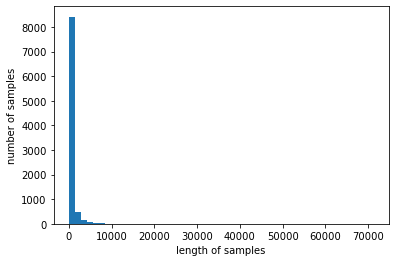

In [92]:
print('메일의 최대 길이 : %d' % max(len(sample) for sample in X_train_encoded))
print('메일의 평균 길이 : %f' % (sum(map(len, X_train_encoded))/len(X_train_encoded)))
plt.hist([len(sample) for sample in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [93]:
max_len = 6737
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)
print("훈련 데이터의 크기(shape):", X_train_padded.shape)

훈련 데이터의 크기(shape): (9233, 6737)


In [104]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=6737))
model.add(SimpleRNN(hidden_units))
model.add(Dense(20, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train_padded, y, epochs=4, batch_size=256, validation_split=0.3)

# 너무 오래걸리고 정확도도 낮음. 

Epoch 1/4
26/26 [==============================] - 127s 5s/step - loss: 2.9981 - acc: 0.0591 - val_loss: 2.9959 - val_acc: 0.0690
Epoch 2/4
 1/26 [>.............................] - ETA: 2:00 - loss: 2.8112 - acc: 0.3320

KeyboardInterrupt: 

## 워드투벡터

In [186]:
# countvectorizer 사용 9233 * 143522
train_X

<9233x143522 sparse matrix of type '<class 'numpy.int64'>'
	with 649556 stored elements in Compressed Sparse Row format>

In [197]:
train_X

0        even washington might consider patty bust id ...
1        run spacenews views stareach bbs localoperati...
2        worry masons demonized harrassed almost every...
3        brendan mckay maybe arf would come rescue naz...
4        help running sample problems oreilly volume x...
                              ...                        
9228     precisely cuba hatians ruled thugs elected le...
9229     custom resume disk macintosh ibm compatible n...
9230     throughout years israelarabpalestinian confli...
9231     anyone know devices available mac whichwill i...
9232     give break chum telling clinton reno know bat...
Name: text, Length: 9233, dtype: object

In [198]:
from nltk.tokenize import word_tokenize, sent_tokenize

In [200]:
sent_text = sent_tokenize(train_X[0])

In [204]:
sent_text

[' even washington might consider patty bust id reworkthat trade minute druce complete utter bust hereonly goals']

In [205]:
result = word_tokenize(sent_text[0])

In [206]:
result

['even',
 'washington',
 'might',
 'consider',
 'patty',
 'bust',
 'id',
 'reworkthat',
 'trade',
 'minute',
 'druce',
 'complete',
 'utter',
 'bust',
 'hereonly',
 'goals']

In [207]:
len(train_X)

9233

In [237]:
train_X_token = []
for i in range(len(train_X)):
    try:
        sent_text = sent_tokenize(train_X[i])
        result = word_tokenize(sent_text[0])
        train_X_token.append(result)
    except:
        print(i)
        pass

400
480
632
752
1120
1143
1204
1304
1334
1364
1377
1591
1755
1846
1962
2031
2067
2259
2281
2356
2398
2453
2512
2656
2764
2768
2769
2956
3012
3254
3399
3670
3703
3734
3789
3861
3878
3943
3958
3993
4095
4139
4278
4356
4383
4568
4600
4679
4686
4690
4813
4970
5216
5229
5554
5737
5815
6035
6056
6070
6096
6106
6282
6502
6802
6907
7011
7105
7128
7172
7378
7438
7698
7892
7905
7993
8029
8180
8200
8326
8456
8551
8840
8884
8889
8898
8918
8974


In [238]:
train_X_token

[['even',
  'washington',
  'might',
  'consider',
  'patty',
  'bust',
  'id',
  'reworkthat',
  'trade',
  'minute',
  'druce',
  'complete',
  'utter',
  'bust',
  'hereonly',
  'goals'],
 ['run',
  'spacenews',
  'views',
  'stareach',
  'bbs',
  'localoperation',
  'running',
  'wwiv',
  'software',
  'capability',
  'link',
  'toover',
  'bbss',
  'usa',
  'canada',
  'wwivnet',
  'started',
  'couple',
  'months',
  'ago',
  'sub',
  'uscurrently',
  'subscribed',
  'ten',
  'boards',
  'moreare',
  'added',
  'get',
  'news',
  'articles',
  'internet',
  'via',
  'ftp',
  'nasasites',
  'variety',
  'aerospace',
  'related',
  'periodicals',
  'weget',
  'fair',
  'amount',
  'questions',
  'space',
  'topics',
  'studentswho',
  'access',
  'system'],
 ['worry',
  'masons',
  'demonized',
  'harrassed',
  'almost',
  'every',
  'major',
  'xian',
  'church',
  'centuries',
  'still',
  'stand',
  'wil',
  'withstand',
  'miserable',
  'southern',
  'boobtists',
  'surethey',


In [241]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences=result, vector_size=100, sg=0)


In [247]:
model.

AttributeError: 'Word2Vec' object has no attribute 'vectors'

## 보팅

In [35]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [36]:
import re 

def clean_text(texts): 
  corpus = [] 
  for i in range(0, len(texts)): 

    review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>]', '',texts[i]) #@%*=()/+ 와 같은 문장부호 제거
    review = re.sub(r'\d+','', review)#숫자 제거
    review = review.lower() #소문자 변환
    review = re.sub(r'\s+', ' ', review) #extra space 제거
    review = re.sub(r'<[^>]+>','',review) #Html tags 제거
    review = re.sub(r'\s+', ' ', review) #spaces 제거
    review = re.sub(r"^\s+", '', review) #space from start 제거
    review = re.sub(r'\s+$', '', review) #space from the end 제거
    review = re.sub(r'_', ' ', review) #space from the end 제거
    corpus.append(review) 
  
  return corpus

In [37]:
temp = clean_text(train['text']) #메소드 적용
train['text'] = temp
train.head()

,text,target
0,they were and even if washington might conside...,10
1,we run spacenews views on our stareach bbs a l...,14
2,not to worry the masons have been demonized an...,19
3,only brendan mckay or maybe arf would come to ...,17
4,help i am running some sample problems from or...,5


In [38]:
temp = clean_text(test['text']) #메소드 적용
test['text'] = temp
test.head()

,text
0,the vlide adapter can be much faster then the ...
1,yeah in a fire that reportedly burned hotter t...
2,judge i grant you immunity from whatever may b...
3,i too put a corbin seat on my hawk i got the s...
4,do i ever after years of having health problem...


In [39]:
train_X = train['text']
train_y = train['target']

In [40]:
train_X

0       they were and even if washington might conside...
1       we run spacenews views on our stareach bbs a l...
2       not to worry the masons have been demonized an...
3       only brendan mckay or maybe arf would come to ...
4       help i am running some sample problems from or...
                              ...                        
9228    precisely why not cuba why not the hatians are...
9229    your custom resume on disk macintosh or ibm co...
9230    throughout the years of the israelarabpalestin...
9231    does anyone know if there are any devices avai...
9232    give me a break chum are you telling me that c...
Name: text, Length: 9233, dtype: object

In [41]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english')) 

In [42]:
for i in range(len(train_X)):
    a = train_X[i].split(' ')
    result = ''
    for word in a: 
        if word not in stop_words: 
            result = result + ' ' + word 
    train_X[i] = result

train_X

0        even washington might consider patty bust id ...
1        run spacenews views stareach bbs localoperati...
2        worry masons demonized harrassed almost every...
3        brendan mckay maybe arf would come rescue naz...
4        help running sample problems oreilly volume x...
                              ...                        
9228     precisely cuba hatians ruled thugs elected le...
9229     custom resume disk macintosh ibm compatible n...
9230     throughout years israelarabpalestinian confli...
9231     anyone know devices available mac whichwill i...
9232     give break chum telling clinton reno know bat...
Name: text, Length: 9233, dtype: object

In [43]:
for i in range(len(test.text)):
    a = test.text[i].split(' ')
    result = ''
    for word in a: 
        if word not in stop_words: 
            result = result + ' ' + word 
    test.text[i] = result

test

,text
0,vlide adapter much faster normal ide depends ...
1,yeah fire reportedly burned hotter degrees ho...
2,judge grant immunity whatever may learned key...
3,put corbin seat hawk got solo seat whichcould...
4,ever years health problems beencleared waller...
...,...
9228,texas cannot carry handgun period either conc...
9229,yes want concentrate development issues ive c...
9230,know megadrives worked perfectly mymac plus p...
9231,oops quite right got busy saved franks last p...


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [45]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words = 'english')

vectorizer.fit(np.array(train["text"]))

train_vec = vectorizer.transform(train["text"])
train_y = train["target"]

test_vec = vectorizer.transform(test["text"])

In [52]:
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

In [53]:
MLP = MLPClassifier()
NB = MultinomialNB()
LGBM = LGBMClassifier()

VC = VotingClassifier(estimators=[('mlp',MLP),('nb',NB),('lgbm',LGBM)],voting = 'soft')

In [54]:
VC.fit(train_vec,train_y)

KeyboardInterrupt: 

In [56]:
model = MLPClassifier()
model.fit(train_vec, train_y)

MLPClassifier()